In [ ]:
import torch
import torch.nn.functional as F
from torchvision import datasets,transforms, models
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted
from PIL import Image
import os
from torchvision.models.vgg import VGG

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
main_dir = './drive/My Drive/hw5/training/image_2'
label_dir = './drive/My Drive/hw5/training/semantic'

# Loading model
model_ft = models.vgg16(pretrained= True)
# Loading convolution layers separately
features = list(model_ft.features.children())
# Loading dense layers
classifier = list(model_ft.classifier.children())
#Input features of layer 1 are padded 100x100
features[0].padding=(100,100)

In [ ]:
class FCN16VGG(nn.Module):
    def __init__(self, num_classes = 35):
        super(FCN16VGG, self).__init__()
      
        features, classifier = list(model_ft.features.children()), list(model_ft.classifier.children())

        features[0].padding = (100, 100)

        for f in features:
            if 'MaxPool' in f.__class__.__name__:
                f.ceil_mode = True
            elif 'ReLU' in f.__class__.__name__:
                f.inplace = True

        self.features4 = nn.Sequential(*features[: 24])
        self.features5 = nn.Sequential(*features[24:])

        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool4.weight.data.zero_()
        self.score_pool4.bias.data.zero_()

        fc6 = nn.Conv2d(512, 4096, kernel_size=7)
        fc7 = nn.Conv2d(4096, 4096, kernel_size=1)
        score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)
        self.score_fr = nn.Sequential(
            fc6, nn.ReLU(inplace=True), nn.Dropout(), fc7, nn.ReLU(inplace=True), nn.Dropout(), score_fr
        )

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, bias=False)
        self.upscore16 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=32, stride=16, bias=False)

    def forward(self, x):
        x_size = x.size()
        pool4 = self.features4(x)
        pool5 = self.features5(pool4)

        score_fr = self.score_fr(pool5)
        upscore2 = self.upscore2(score_fr)

        score_pool4 = self.score_pool4(0.01 * pool4)
        upscore16 = self.upscore16(score_pool4[:, :, 5: (5 + upscore2.size()[2]), 5: (5 + upscore2.size()[3])]
                                   + upscore2)
        return upscore16[:, :, 27: (27 + x_size[2]), 27: (27 + x_size[3])].contiguous()

In [ ]:

model = FCN16VGG().to(device)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, main_dir, label_dir, transform):
        self.main_dir = main_dir
        self.label_dir = label_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        all_imgs_label = os.listdir(label_dir)
        self.total_imgs = natsorted(all_imgs)
        self.total_imgs_label = natsorted(all_imgs_label)
        
    def __len__(self):
        return len(self.total_imgs)
    
    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        img_loc_label = os.path.join(self.label_dir, self.total_imgs_label[idx] )
        image = Image.open(img_loc).convert('RGB')
        labels = Image.open(img_loc_label).convert('P')
        tensor_image = self.transform(image)
        tensor_label = self.transform(labels)
        return (tensor_image, (tensor_label*255).type(torch.LongTensor))

In [ ]:
transform = transforms.Compose([transforms.Resize((256,1024)),
                                transforms.ToTensor()])

train_data = CustomDataset(main_dir, label_dir, transform)

length_train=int(0.7*len(train_data))
length_val= int(0.15*len(train_data))
length_test = len(train_data) - length_train - length_val

train, val, test = torch.utils.data.random_split(train_data, [length_train, length_val, length_test])


training_loader = torch.utils.data.DataLoader(train, batch_size=1, shuffle=False)
validation_loader = torch.utils.data.DataLoader(val, batch_size = 1, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size = 1, shuffle = False)

In [ ]:
for image, labels in training_loader:
  print(image.size(), labels.size())
  break

torch.Size([1, 3, 256, 1024]) torch.Size([1, 1, 256, 1024])


In [ ]:
from sklearn.metrics import jaccard_score as jsc

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001) # fine tuned the lr

In [ ]:
epochs = 100
running_loss_history = []
val_running_loss_history = []

for e in range(epochs):
    predlist=torch.zeros(0,dtype=torch.long, device='cpu')
    labellist=torch.zeros(0,dtype=torch.long, device='cpu')

    predlist_val=torch.zeros(0,dtype=torch.long, device='cpu')
    labellist_val=torch.zeros(0,dtype=torch.long, device='cpu')
    running_loss = 0.0
    val_running_loss = 0.0
    
    
    for inputs, labels in training_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels[:,0])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _,preds = torch.max(outputs, dim = 1)
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        labellist=torch.cat([labellist,labels.view(-1).cpu()])

    

    else:
      with torch.no_grad(): # we do not need gradient for validation.
        for val_inputs, val_labels in validation_loader:
          val_inputs = val_inputs.to(device)
          val_labels = val_labels.to(device)
          val_outputs = model(val_inputs)
          val_loss = criterion(val_outputs, val_labels[:,0])
          
          _, val_preds = torch.max(val_outputs, 1)
          val_running_loss += val_loss.item()

          predlist_val=torch.cat([predlist_val,val_preds.view(-1).cpu()])
          labellist_val=torch.cat([labellist_val,val_labels.view(-1).cpu()])

    lbl = predlist.cpu().numpy().reshape(-1)
    target = labellist.cpu().numpy().reshape(-1)
    iou_micro = jsc(target, lbl, average = 'micro' )
    iou_macro = jsc(target, lbl, average = 'macro' )

    epoch_loss = running_loss/len(training_loader)
    running_loss_history.append(epoch_loss)
    val_epoch_loss = val_running_loss/len(validation_loader)
    val_running_loss_history.append(val_epoch_loss)

    lbl_val = predlist_val.cpu().numpy().reshape(-1)
    target_val = labellist_val.cpu().numpy().reshape(-1)
    iou_val_micro = jsc(target_val, lbl_val, average = 'micro' )
    iou_val_macro = jsc(target_val, lbl_val, average = 'macro' )

    print('epoch :', (e+1))       
    print('training loss: {:.4f}, training iou(macro): {:.4f}, training iou(micro): {:.4f}'.format(epoch_loss, iou_macro, iou_micro))
    print('validation loss: {:.4f}, validation iou(macro): {:.4f}, validation iou(micro): {:.4f}'.format(val_epoch_loss, iou_val_macro, iou_val_micro))

      
        
        
        
    
    
    
    
    
    

epoch : 1
training loss: 1.4024, training iou(macro): 0.0931, training iou(micro): 0.4709
validation loss: 1.0820, validation iou(macro): 0.1340, validation iou(micro): 0.5705
epoch : 2
training loss: 0.8776, training iou(macro): 0.1325, training iou(micro): 0.6003
validation loss: 0.8155, validation iou(macro): 0.1560, validation iou(micro): 0.6275
epoch : 3
training loss: 0.7229, training iou(macro): 0.1609, training iou(micro): 0.6418
validation loss: 0.7801, validation iou(macro): 0.1861, validation iou(micro): 0.6445
epoch : 4
training loss: 0.6615, training iou(macro): 0.2060, training iou(micro): 0.6658
validation loss: 0.7796, validation iou(macro): 0.1892, validation iou(micro): 0.6479
epoch : 5
training loss: 0.6093, training iou(macro): 0.2205, training iou(micro): 0.6777
validation loss: 0.9777, validation iou(macro): 0.1792, validation iou(micro): 0.5807
epoch : 6
training loss: 0.6065, training iou(macro): 0.2495, training iou(micro): 0.6906
validation loss: 0.8658, valid

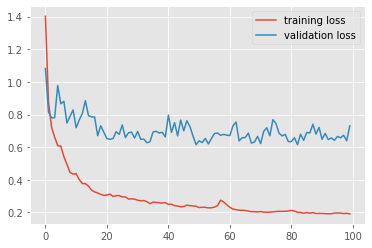

In [ ]:
plt.style.use('ggplot')
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

In [ ]:
# Evaluating model performance on test set
test_running_corrects = 0.0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
labellist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad(): # we do not need gradient for validation.
      for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_preds = torch.max(test_outputs, 1)
        predlist=torch.cat([predlist,test_preds.view(-1).cpu()])
        labellist=torch.cat([labellist,test_labels.view(-1).cpu()])
        test_running_corrects += torch.sum(test_preds == test_labels[:,0].data)


test_acc = test_running_corrects.float()/ (len(test_loader)*256*1024)
print('test acc {:.4f} '.format(test_acc))

test acc 0.8180 


In [ ]:
# IOU calculation for test set

from sklearn.metrics import jaccard_score as jsc

lbl = predlist.cpu().numpy().reshape(-1)
target = labellist.cpu().numpy().reshape(-1)
print(jsc(target, lbl, average = 'micro' ))

0.6920701745930639


In [ ]:
#INFERENCE BLOCK. To Retreive predictions for any single image.

final_data = torch.utils.data.DataLoader(train_data, batch_size=1, shuffle=False)
test_running_corrects = 0.0
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
labellist=torch.zeros(0,dtype=torch.long, device='cpu')
i = 0
# indicates the index of image that is to be retrieved
index= 168
with torch.no_grad(): # we do not need gradient for validation.
      for test_inputs, test_labels in final_data:
        if i == index:
          test_inputs = test_inputs.to(device)
          test_labels = test_labels.to(device)
          test_outputs = model(test_inputs)
          _, test_preds = torch.max(test_outputs, 1)
          predlist=torch.cat([predlist,test_preds.view(-1).cpu()])
          labellist=torch.cat([labellist,test_labels.view(-1).cpu()])
          test_running_corrects += torch.sum(test_preds == test_labels[:,0].data)
          break
        else:
            i +=1

test acc 0.7786 


In [ ]:
# This is the labels.py file (renamed to id_labels) which contains id to color mapping
import id_labels

In [ ]:
from collections import defaultdict
d = defaultdict(set)
L = id_labels.labels
for i in range(len(L)):
  d[L[i][1]] = L[i][-1]



In [ ]:
predictions = test_preds.cpu().numpy()
predictions.shape

(1, 256, 1024)

In [ ]:
lst = []
p = predictions[0,:]
for i in range(len(p)):
  for j in range(len(p[i])):
    lst.append((d[p[i][j]]))


In [ ]:
arr = np.array(lst)

In [ ]:
arr = np.reshape(arr,[256,1024,3])

In [ ]:
g = np.zeros([256,1024,3])
for i in range(len(arr)):
  for j in range(len(arr[i])):
    for k in range(len(arr[i][j])):
      g[i][j][k] = arr[i][j][k]/255.0

In [ ]:
import cv2
cv2.imwrite('color_img.jpg',arr)
c = cv2.imread('color_img.jpg', 1)
c = cv2.cvtColor(c, cv2.COLOR_BGR2RGB)
cv2.imwrite('Final_img.jpg', c)

True

In [ ]:
torch.save(model, "./drive/My Drive/hw5/entire_model_fcn16.pt")

In [ ]:
model = torch.load('./drive/My Drive/hw5/entire_model_fcn16.pt')

In [ ]:
model.eval()

FCN16VGG(
  (features4): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, di